## 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 정규방정식을 이용한 선형회귀

In [2]:
# 정규방정식을 테스트해 보기 위해 선형처럼 보이는 데이터를 생성한다

import numpy as np

X = 2 * np.random.rand(100, 1)  # 100x1 크기의 0~1 사이의 값으로 이루어진 값을 리턴
y = 4 + 3 * X + np.random.randn(100, 1)  # 100x1 크기의 정규분포를 따르는 값을 리턴

.rand() : Random values in a given shape  
.randn() : Return a sample from the "standard normal" distribution

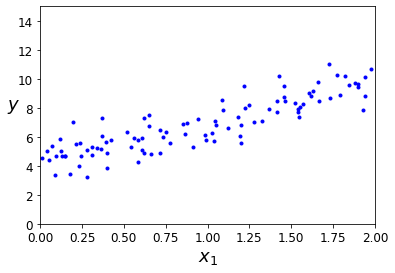

In [3]:
# 그래프 그리기

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [4]:
# 선형 데이터를 생성했고 이제 정규방정식을 이용해 세타^hat을 계산한다

X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0=1을 추가한다
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
# 구한 세타 출력해 보기

theta_best

array([[4.21509616],
       [2.77011339]])

이 데이터를 생성하기 위해 사용한 함수는 y = 4 + 3x + 가우시안_잡음 이었다.  
즉 세타0 = 4, 세타1 = 3이 나오길 기대했는데 잡음 떄문에 원래 함수의 파라미터를 정확하게 재현하지 못했다.  
구한 세타^ 을 사용해 예측을 해보자 <- (y^ = X세타^)

In [6]:
# 구한 세타^hat 을 사용해 예측을 해보자

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0=1을 추가한다
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

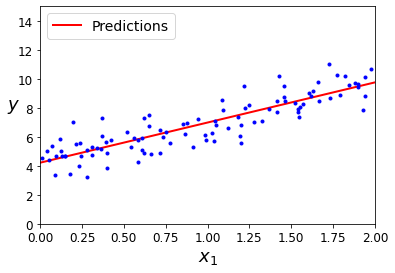

In [7]:
# 모델의 예측을 그래프로 나타내자

plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [8]:
# 사이킷 런에서 선형 회귀를 수행한다

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_  # .intercept_(편향), .coef_(가중치)

(array([4.21509616]), array([[2.77011339]]))

In [9]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

LinearRegression 클래스는 scipy.linalg.lstsq() 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있습니다:

In [10]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

# 앞에서 한 정규방정식 대체 ?~?

array([[4.21509616],
       [2.77011339]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산합니다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 유사역행렬 (pseudoinverse)입니다(Moore–Penrose 유사역행렬입니다). np.linalg.pinv()을 사용해서 유사역행렬을 직접 계산할 수 있습니다:

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 배치 경사 하강법을 사용한 선형 회귀

In [12]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)  # 초기값은 랜덤으로 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [13]:
theta

array([[4.21509616],
       [2.77011339]])

In [14]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [15]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

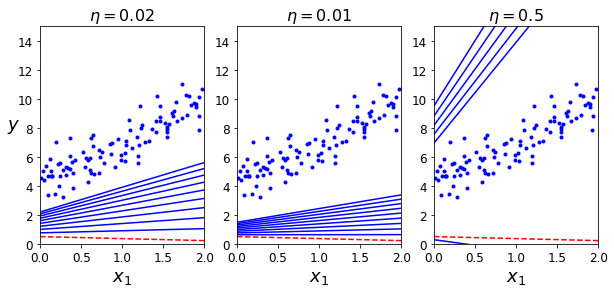

In [16]:
np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize = (10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta = 0.02)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(132); plot_gradient_descent(theta, eta = 0.01, theta_path = theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta = 0.5)

plt.show()

## 확률적 경사 하강법

In [17]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

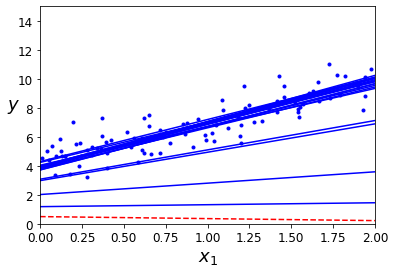

In [18]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [19]:
theta

array([[4.21076011],
       [2.74856079]])

In [20]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1, random_state = 42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_
# 결과를 보면 정규방정식으로 구한 것과 매우 비슷하다.

(array([4.24365286]), array([2.8250878]))

## 미니배치 경사 하강법

In [22]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffeled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffeled[i:i + minibatch_size]
        yi = y_shuffled[i:i + minibatch_size]
        gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [23]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [24]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


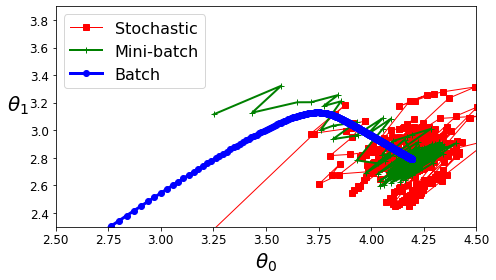

In [25]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## 다항 회귀

In [26]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [27]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)  # 2차방정식으로 비선형 데이터를 생성, 약간의 잡음으 포함한다.

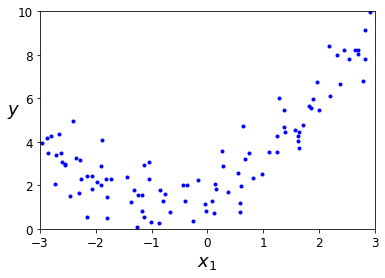

In [28]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.axis([-3, 3, 0, 10])
plt.show()

직선은 이 데이터에 잘 맞지 않는다.  
따라서 사이킷런의 PolynomialFeatures로 훈련 데이터를 변환한다.  
훈련 세트의 각 특성을 제곱해서 새로운 특성으로 추가해 준다.  

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [30]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [31]:
# 이 확장된 훈련 데이터에 Linear Regression을 적용한다.

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

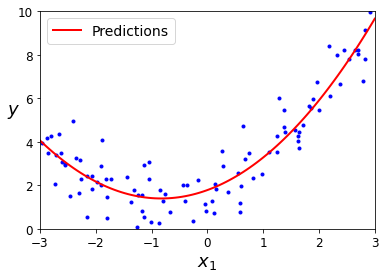

In [32]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc = "upper left", fontsize = 14)
plt.axis([-3, 3, 0, 10])
plt.show()

## 학습 곡선

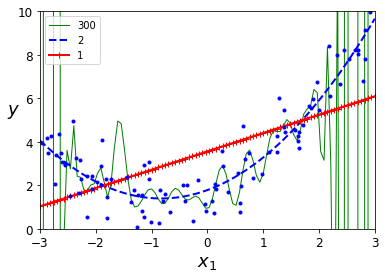

In [33]:
# 고차 다항 회귀 그래프로 나타내기

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree = degree, include_bias = False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg)
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()


고차 다항 회귀 모델은 심각하게 훈련 데이터에 과대적합되었다.  
선형 모델은 과소적합이다.  
가장 일반화가 잘 된건 2차 다항 회귀다. (즉, 2차 방정식으로 생성한 데이터)

In [34]:
# 주어진 훈련 데이터에서 모델의 학습 곡선을 그리는 함수

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 책에는 없음
    plt.xlabel("Training set size", fontsize=14) # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)              # 책에는 없음

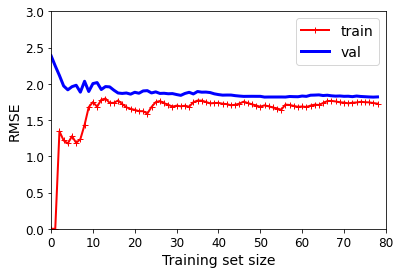

In [35]:
# 단순 선형 회귀 모델의 학습 곡선을 살펴본다.

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

과소적합 모델의 전형적인 학습곡선 모습이다.

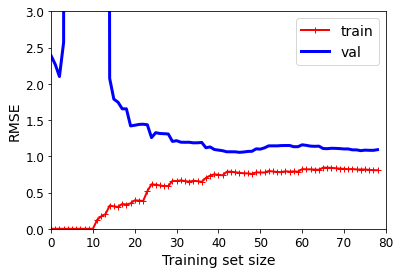

In [36]:
# 위와 같은 데이터에서 10차 다항 회귀 모델의 학습 곡선을 그려본다.

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()


- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮다.
- 두 곡선 사이에 공간이 있다. -> 훈련 데이터에서의 성능이 검증 데이터에서보다 훨씬 낫다. -> "과대적합"  
- 하지만 더 큰 훈련 세트를 사용하면 두 곡선은 점점 가까워진다.

## 규제가 있는 모델
### 릿지 회귀

In [37]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

### *np.linspace(start, stop, num) 함수
linspace -> Linearly Spaced의 줄임말  
start 숫자부터 stop 숫자까지를 num개의 요소로 만든 1차원 배열을 반환한다.

In [38]:
# 사이킷런에서 정규방정식을 사용해서 릿지 회귀를 적용했을 때

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 1, solver = "cholesky", random_state = 42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [39]:
# 사이킷런에서 확률적 평균 경사 하강법을 사용해서 릿지 회귀를 적용했을 때
# solver = "sag"를 넣어주면 된다.
# sagd는 SGD의 변종이다.
ridge_reg = Ridge(alpha = 1, solver = "sag", random_state = 42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

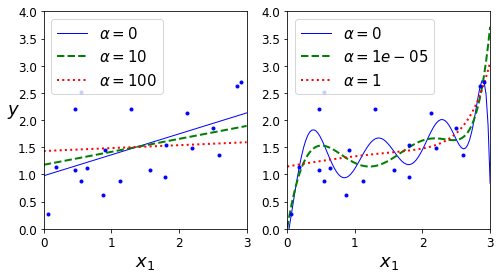

In [40]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

In [41]:
# 확률적 경사 하강법을 사용했을 때

sgd_reg = SGDRegressor(penalty = "l2", max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### 라쏘 회귀

c:\Users\dahyeon\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


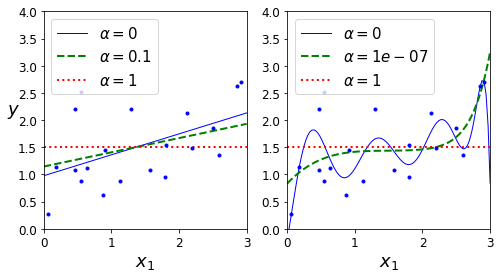

In [43]:
# Lasso 클래스를 사용한 예제

from sklearn.linear_model import Lasso

plt.figure(figsize = (8, 4))
plt.subplot(121)
plot_model(Lasso, polynomial = False, alphas = (0, 0.1, 1), random_state = 42)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

In [44]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

# Lasso 대신 SGDRegressor(penalty = "l1")을 사용할 수도 있다.

array([1.53788174])

### 엘라스틱넷

In [45]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5, random_state = 42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 조기 종료

In [46]:
# 조기 종료 코드 구현해 보기 전에 데이터 준비하기

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size = 0.5, random_state = 10)

In [47]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

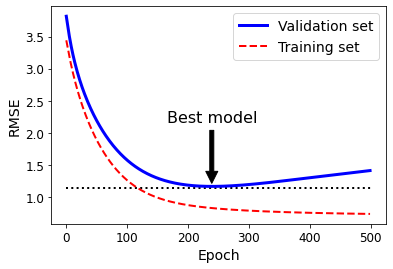

In [48]:
# 그래프 그리기

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

In [49]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

## 로지스틱 회귀

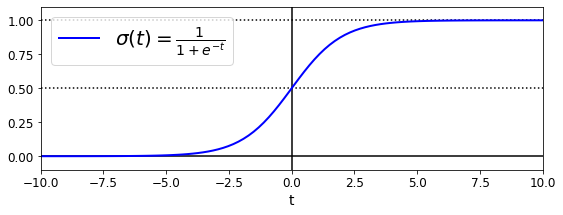

In [50]:
# 시그모이드 함수 그래프

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])

plt.show()

### 결정 경계
붓꽃 데이터셋을 이용해서 로지스틱 회귀를 구현해 본다.

In [51]:
# 먼저 데이터를 로드한다.

from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [54]:
print(iris.DESCR)
# print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========